# dynoNet: Solution 
## Application to Ground Vibration Test of an F-16 aircraft. Description of the benchmark: https://www.nonlinearbenchmark.org/benchmarks/f-16-gvt

### Course on Deep Learning for System Identification
### Authors: Dario Piga, Marco Forgione
### Lugano, April 8th, 2024

Repeat the same exercise on the identification of the F16 aircraft.  **Use a dynoNet** instead of Feedforward and RNN networks.

Hyper-parameter to select:
* structure of the network 
* input and output lags of the LTI blocks
* structure of the Static Nonlinearities
* sub-sequence length for training and batch size
* number of initial samples skipped in the creation of the loss 
* optimizer's hyper-parameters (learning rate, maximum number of epochs)

Run the following cell to import possible useful packages and classes.

In [4]:
import matplotlib.pyplot as plt
import os
import numpy as np
import dynonet
from dynonet.lti import MimoLinearDynamicalOperator
from dynonet.static import MimoStaticNonLinearity
from sklearn.preprocessing import StandardScaler
import pandas as pd
import torch 
import torch.nn as nn # the pytorch nn model contains all the layers we need to define a feedforward NN 
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from sklearn.metrics import r2_score

# Enable interactive figures for Jupyter Notebooks.
%matplotlib widget 
from torch.utils.data import Dataset, DataLoader
from dataset_complete import F16DS_seq, CED_seq, WH2009_seq, SB_seq, SB_MS_seq, CT_seq, EMPS_seq, create_dataset

Since dynoNet receives as an input the input sequence of the system, the same *DataSet* class *F16DS_seq* used for training RNN can be also used in this exercise. Each element of the *F16DS_seq* Dataset is a pair with:
- input sub-sequences of a given length (since we are considering two inputs, we have 2 input sub-sequences)
- corresponding output sequences (if you consider all the three outputs, you will have 3 outputs)

For your convenience, you can run the cell below to upload the dataset and instantiate the *F16DS_seq* class.

In [5]:
class my_dynoNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_a=10, n_b=10):
        super(my_dynoNet, self).__init__()
    

        # PyTorch class that holds layers in a list
        self.G1 = MimoLinearDynamicalOperator(in_channels = input_size, out_channels = 5, n_b = n_b, n_a = n_a, n_k=1)
        self.L1 = MimoStaticNonLinearity(5, 8, n_hidden=hidden_size) 
        self.G2 = MimoLinearDynamicalOperator(in_channels = 8, out_channels = output_size, n_b = n_b, n_a = n_a, n_k=1)
        
                
    def forward(self, x):
        
        x = self.G1(x)
        x = self.L1(x)
        y = self.G2(x)
        
        return y



net = my_dynoNet(input_size = 1, hidden_size = 20,  output_size = 1, n_a = 10, n_b = 10)
print(net)

my_dynoNet(
  (G1): MimoLinearDynamicalOperator()
  (L1): MimoStaticNonLinearity(
    (net): Sequential(
      (0): Linear(in_features=5, out_features=20, bias=True)
      (1): Tanh()
      (2): Linear(in_features=20, out_features=8, bias=True)
    )
  )
  (G2): MimoLinearDynamicalOperator()
)


In [6]:
def train(model, loader, lr, max_epochs, n_skip = 0):

    #Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    print('Optimization started \n')
    print(f"max:epochs: {max_epochs}")
    
    for epoch in range(max_epochs):
        
        loss_tot = 0
        
        for u, y in loader:  
            
            # forward pass
            y_hat = model(u)
            loss = torch.mean( (y_hat[:,n_skip:,:] - y[:,n_skip:,:])**2 )
    
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                loss_tot += loss
            
    
        if epoch % 1 == 0: # print
            print(f'Epoch [{epoch+1}/{max_epochs}], Loss: {loss_tot.item()}')

    return model
    


CED
Optimization started 

max:epochs: 100
Epoch [1/100], Loss: 0.9731473326683044
Epoch [2/100], Loss: 0.9723343849182129
Epoch [3/100], Loss: 0.9717401266098022
Epoch [4/100], Loss: 0.9713348150253296
Epoch [5/100], Loss: 0.9710938334465027
Epoch [6/100], Loss: 0.9709869623184204
Epoch [7/100], Loss: 0.9709634184837341
Epoch [8/100], Loss: 0.9709522128105164
Epoch [9/100], Loss: 0.970889687538147
Epoch [10/100], Loss: 0.9707486033439636
Epoch [11/100], Loss: 0.9705331921577454
Epoch [12/100], Loss: 0.9702605605125427
Epoch [13/100], Loss: 0.9699480533599854
Epoch [14/100], Loss: 0.9696070551872253
Epoch [15/100], Loss: 0.9692420959472656
Epoch [16/100], Loss: 0.9688513875007629
Epoch [17/100], Loss: 0.9684285521507263
Epoch [18/100], Loss: 0.9679632186889648
Epoch [19/100], Loss: 0.9674439430236816
Epoch [20/100], Loss: 0.9668595194816589
Epoch [21/100], Loss: 0.9662009477615356
Epoch [22/100], Loss: 0.9654629826545715
Epoch [23/100], Loss: 0.9646447896957397
Epoch [24/100], Loss: 0.

C:\Users\dario.piga\AppData\Local\Temp\ipykernel_15208\3666247109.py:94: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Optimization started 

max:epochs: 100
Epoch [1/100], Loss: 0.9929826855659485
Epoch [2/100], Loss: 0.992337167263031
Epoch [3/100], Loss: 0.9912882447242737
Epoch [4/100], Loss: 0.9897499680519104
Epoch [5/100], Loss: 0.9876811504364014
Epoch [6/100], Loss: 0.9850048422813416
Epoch [7/100], Loss: 0.981623113155365
Epoch [8/100], Loss: 0.9774306416511536
Epoch [9/100], Loss: 0.9723153114318848
Epoch [10/100], Loss: 0.9661550521850586
Epoch [11/100], Loss: 0.9588159918785095
Epoch [12/100], Loss: 0.9501500725746155
Epoch [13/100], Loss: 0.9399937987327576
Epoch [14/100], Loss: 0.9281702041625977
Epoch [15/100], Loss: 0.9144895672798157
Epoch [16/100], Loss: 0.8987497091293335
Epoch [17/100], Loss: 0.8807380199432373
Epoch [18/100], Loss: 0.8602349162101746
Epoch [19/100], Loss: 0.8370181322097778
Epoch [20/100], Loss: 0.8108689785003662
Epoch [21/100], Loss: 0.7815805077552795
Epoch [22/100], Loss: 0.7489674091339111
Epoch [23/100], Loss: 0.7128814458847046
Epoch [24/100], Loss: 0.67322

ValueError: Input contains NaN.

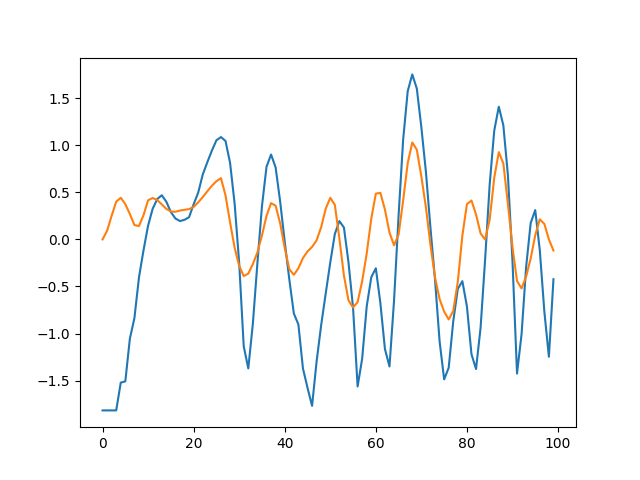

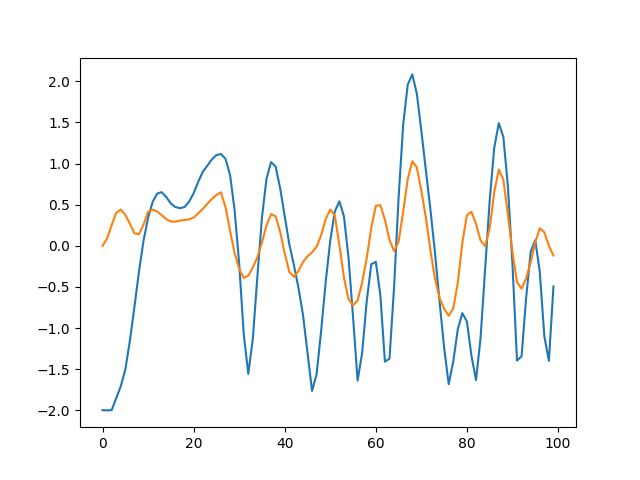

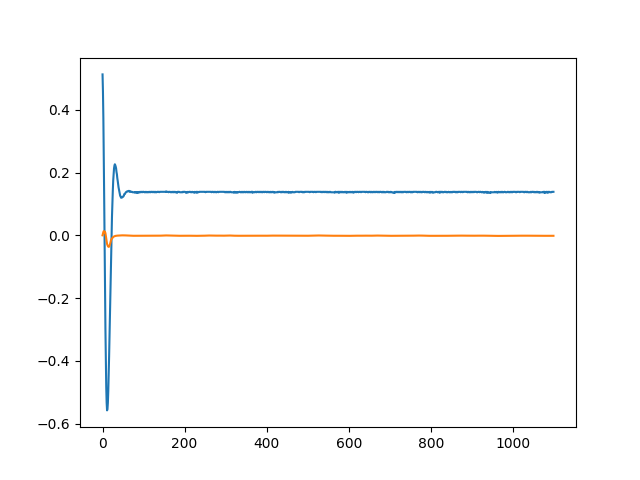

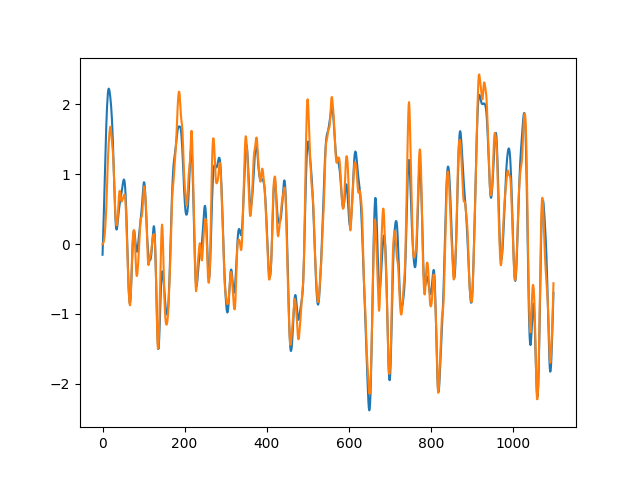

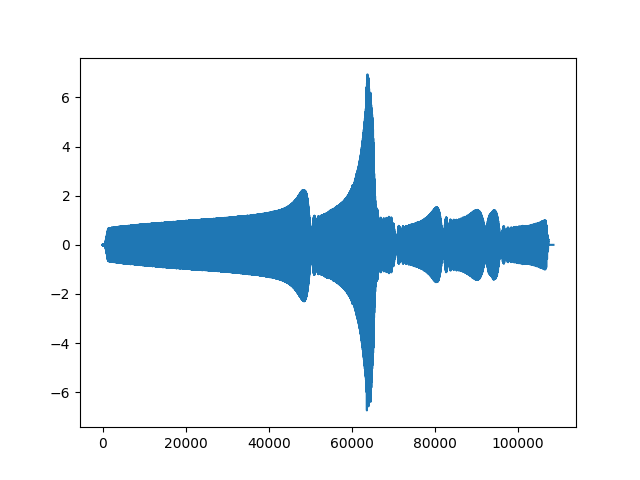

In [11]:
# Maps of benchmarks
# Maps of benchmarks
config_train = {
    'CED': {'class': CED_seq, 'params': {'seq_len': 100}},
    'WH2009': {'class': WH2009_seq, 'params': {'seq_len': 1100}},
    'F16': {'class': F16DS_seq, 'params': {'seq_len': 'all', 'ind_out': [0]}},
    'SB': {'class': SB_seq, 'params': {'seq_len': 1310}},
    'SB_MS': {'class': SB_MS_seq, 'params': {'seq_len': 131}},
    'CT': {'class': CT_seq, 'params': {'seq_len': 'all'}},
    'EMPS': {'class': EMPS_seq, 'params': {'seq_len': 24}},
}

file_map_train = {
    'CED': os.path.join('..', 'Datasets', 'CED', 'DATAPRBS.csv'),
    'WH2009': os.path.join('..', 'Datasets', 'WH2009', 'WienerHammerBenchmark.csv'),
    'F16': os.path.join('..', 'Datasets', 'F16', 'F16Data_SineSw_Level3.csv'),
    'SB': os.path.join('..', 'Datasets', 'Silverbox', 'SNLS80mV.csv'),
    'SB_MS': os.path.join('..', 'Datasets', 'Silverbox', 'Schroeder80mV.csv'),
    'CT': os.path.join('..','Datasets','CascadedTanks','dataBenchmark.csv'),
    'EMPS': os.path.join('..', 'Datasets', 'EMPS', 'DATA_EMPS.mat')
}

config_test = {
    'CED': {'class': CED_seq, 'params': {'seq_len': 100}},
    'WH2009': {'class': WH2009_seq, 'params': {'seq_len': 1100}},
    'F16': {'class': F16DS_seq, 'params': {'seq_len': 'all', 'ind_out': [0]}},
    'SB': {'class': SB_seq, 'params': {'seq_len': 1310}},
    'SB_MS': {'class': SB_MS_seq, 'params': {'seq_len': 131}},
    'CT': {'class': CT_seq, 'params': {'seq_len': 'all'}},
    'EMPS': {'class': EMPS_seq, 'params': {'seq_len': 24}},
}


file_map_test = {
    'CED': os.path.join('..', 'Datasets', 'CED', 'DATAPRBS.csv'),
    'WH2009': os.path.join('..', 'Datasets', 'WH2009', 'WienerHammerBenchmark.csv'),
    'F16': os.path.join('..', 'Datasets', 'F16', 'F16Data_SineSw_Level4_Validation.csv'),
    'SB': os.path.join('..', 'Datasets', 'Silverbox', 'SNLS80mV.csv'),
    'SB_MS': os.path.join('..', 'Datasets', 'Silverbox', 'Schroeder80mV.csv'),
    'CT': os.path.join('..','Datasets','CascadedTanks','dataBenchmark.csv'),
    'EMPS': os.path.join('..', 'Datasets', 'EMPS', 'DATA_EMPS_PULSES.mat')
}


params = {
    'CED':  {'batch_size': 100, 'input_size': 1, 'hidden_size': 20,  'output_size': 1, 'n_a': 10, 'n_b': 10, 'lr': 1e-3, 'max_epochs': 100, 'n_skip': 10},
    'WH2009':  {'batch_size': 100, 'input_size': 1, 'hidden_size': 20,  'output_size': 1, 'n_a': 10, 'n_b': 10, 'lr': 1e-3, 'max_epochs': 100, 'n_skip': 10},
    'F16':  {'batch_size': 100, 'input_size': 2, 'hidden_size': 20,  'output_size': 1, 'n_a': 10, 'n_b': 10, 'lr': 1e-3, 'max_epochs': 1000, 'n_skip': 10},
    'SB':  {'batch_size': 100, 'input_size': 1, 'hidden_size': 20,  'output_size': 1, 'n_a': 10, 'n_b': 10, 'lr': 1e-3, 'max_epochs': 1000, 'n_skip': 10},
    'SB_MS':  {'batch_size': 100, 'input_size': 1, 'hidden_size': 20,  'output_size': 1, 'n_a': 10, 'n_b': 10, 'lr': 1e-3, 'max_epochs': 1000, 'n_skip': 10},
    'CT':  {'batch_size': 100, 'input_size': 1, 'hidden_size': 20,  'output_size': 1, 'n_a': 10, 'n_b': 10, 'lr': 1e-3, 'max_epochs': 1000, 'n_skip': 10},
    'EMPS':  {'batch_size': 100, 'input_size': 1, 'hidden_size': 20,  'output_size': 1, 'n_a': 10, 'n_b': 10, 'lr': 1e-3, 'max_epochs': 1000, 'n_skip': 10},
}


#model = my_dynoNet(input_size = input_size, hidden_size = 20,  output_size = len(ind_out))



config = {'train': config_train, 'test': config_test}
file_map = {'train': file_map_train, 'test': file_map_test}
ds = {}

for benchmark in config['train'].keys():  # or 'CED', 'F16'

    print(benchmark)
    for split_map in ['train', 'test']:

        if split_map == 'train':
            ds[split_map], mean_train, std_train = create_dataset(benchmark, config[split_map], file_map[split_map], split_map,  Normalization=True)
        else:
            ds[split_map], _, _ = create_dataset(benchmark, config[split_map], file_map[split_map], split_map,  Normalization=False)


        if split_map == 'train':
            loader = DataLoader(ds['train'], shuffle=True, batch_size=params[benchmark]['batch_size'])
            u, y = next(iter(loader))
            # Extract only the necessary parameters for my_dynoNet constructor
            model_params = {key: params[benchmark][key] for key in ['input_size', 'hidden_size', 'output_size', 'n_a', 'n_b'] if key in params[benchmark]}
            model = my_dynoNet(**model_params)
           
            train_params = {key: params[benchmark][key] for key in ['lr', 'max_epochs', 'n_skip'] if key in params[benchmark]}
            model = train(model, loader, **train_params)
            

            for set_type in ['train', 'test']:
                ds_val, _, _ = create_dataset(benchmark, config['test'], file_map[set_type], set_type,  Normalization=True)
                
                u, y = ds_val[0:]
                print(u.shape, y.shape)
                y_hat = model(u)
    
                for i in range(y.shape[2]):
                    plt.figure()
                    plt.plot(y.detach().numpy()[0,:,i])
                    plt.plot(y_hat.detach().numpy()[0,:,i])
            
                #print(np.mean( (y_hat.detach().numpy()[0,:,:] - y.detach().numpy()[0,:,:])**2 ))
                R2 = r2_score(y[0,:,i].detach().numpy(), y_hat[0,:,i].detach().numpy())
                print(f"Output {i:d}: R2 index: {R2:.2f} : {set_type} ")


In [3]:
input_size = 2
seq_len = 10000 # length of subsequence
batch_size = 4
ind_out = [0, 1, 2] # it should be a list

folder = os.path.join('..', 'Datasets', 'F16')
f_train_ds =  os.path.join(folder, 'F16Data_SineSw_Level3.csv')
f_test_ds = os.path.join(folder, 'F16Data_SineSw_Level4_Validation.csv')


dict_ds = {'train': [], 'test': [],}
dict_ds['train'] = pd.read_csv(f_train_ds) 
dict_ds['test'] = pd.read_csv(f_test_ds)


ds_mean = dict_ds['train'].mean() 
ds_std = dict_ds['train'].std()
dict_ds['train']  = (dict_ds['train'] - ds_mean)/ds_std
dict_ds['test']  = (dict_ds['test'] - ds_mean)/ds_std

F16DS_train = F16DS_seq(pd_file=dict_ds['train'], seq_len = seq_len, ind_out=ind_out)
loader_train = DataLoader(F16DS_train, shuffle=True, batch_size=batch_size)
u, y = next(iter(loader_train))
print(y.shape)




benchmark = 'F16'  # or 'CED', 'F16'
F16DS_train, mean, std = create_dataset(benchmark, Normalization=True)

loader_train = DataLoader(F16DS_train, shuffle=True, batch_size=batch_size)
u, y = next(iter(loader_train))
print(u.shape, y.shape)




NameError: name 'os' is not defined

# Solution

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
import dynonet
from dynonet.lti import MimoLinearDynamicalOperator
from dynonet.static import MimoStaticNonLinearity
from sklearn.preprocessing import StandardScaler
import pandas as pd
import torch 
import torch.nn as nn # the pytorch nn model contains all the layers we need to define a feedforward NN 
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from sklearn.metrics import r2_score

# Enable interactive figures for Jupyter Notebooks.
%matplotlib widget 
from torch.utils.data import Dataset, DataLoader
from dataset import F16DS_seq

In [ ]:
input_size = 2
seq_len = 10000
batch_size = 4
ind_out = [0, 1, 2] # it should be a list



folder = '..\\Datasets\\F16'
f_train_ds =  os.path.join(folder, 'F16Data_SineSw_Level3.csv')
f_test_ds = os.path.join(folder, 'F16Data_SineSw_Level4_Validation.csv')

input_size = 2
seq_len = 10000 # length of subsequence
batch_size = 4
ind_out = [0, 1, 2] # it should be a list

folder = os.path.join('..', 'Datasets', 'F16')
f_train_ds =  os.path.join(folder, 'F16Data_SineSw_Level3.csv')
f_test_ds = os.path.join(folder, 'F16Data_SineSw_Level4_Validation.csv')


dict_ds = {'train': [], 'test': [],}
dict_ds['train'] = pd.read_csv(f_train_ds) 
dict_ds['test'] = pd.read_csv(f_test_ds)


ds_mean = dict_ds['train'].mean() 
ds_std = dict_ds['train'].std()
dict_ds['train']  = (dict_ds['train'] - ds_mean)/ds_std
dict_ds['test']  = (dict_ds['test'] - ds_mean)/ds_std

F16DS_train = F16DS_seq(pd_file=dict_ds['train'], seq_len = seq_len, ind_out=ind_out)
loader_train = DataLoader(F16DS_train, shuffle=True, batch_size=batch_size)
u, y = next(iter(loader_train))
print(y.shape)
dict_ds = {'train': [], 'test': [],}
dict_ds['train'] = pd.read_csv(f_train_ds) 
dict_ds['test'] = pd.read_csv(f_test_ds)


ds_mean = dict_ds['train'].mean() 
ds_std = dict_ds['train'].std()
dict_ds['train']  = (dict_ds['train'] - ds_mean)/ds_std
dict_ds['test']  = (dict_ds['test'] - ds_mean)/ds_std


var_names = ['Force',   'Voltage',  'Acceleration1',  'Acceleration2',  'Acceleration3']
Y_labels = ['N', 'V', '$g$', '$g$', '$g$']


F16DS_train = F16DS_seq(pd_file=dict_ds['train'], seq_len = seq_len, ind_out=ind_out)
loader_train = DataLoader(F16DS_train, shuffle=True, batch_size=batch_size)
u, y = next(iter(loader_train))


In [ ]:
# We extend the nn-Module class of PyTorch. In the constrcutor, we call the constructor of the super class (nn_Module).
# I use the super class to:
# - Automatically track all trainable parameters of the network.
# - Define a forward method that specifies how the network processes input data.
# - Utilize other PyTorch functionalities like backpropagation for training.

class my_dynoNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(my_dynoNet, self).__init__()
        
        n_a = 10
        n_b = 10

        # PyTorch class that holds layers in a list
        self.G1 = MimoLinearDynamicalOperator(in_channels = input_size, out_channels = 5, n_b = n_b, n_a = n_a, n_k=1)
        self.L1 = MimoStaticNonLinearity(5, 8, n_hidden=hidden_size) 
        self.G2 = MimoLinearDynamicalOperator(in_channels = 8, out_channels = output_size, n_b = n_b, n_a = n_a, n_k=1)
        
                
    def forward(self, x):
        
        x = self.G1(x)
        x = self.L1(x)
        y = self.G2(x)
        
        return y



net = my_dynoNet(input_size = input_size, hidden_size = 20,  output_size = len(ind_out))
print(net)

In [ ]:
ckpt_file_dyno = 'out\\ckpt_save_dyn.pt'
epochs = 2000
lr = 1e-3
n_skip = 400
resume = True

# define model

model = my_dynoNet(input_size = input_size, hidden_size = 20,  output_size = len(ind_out))

# check model output for a given input
u, y = next(iter(loader_train))

y_hat = model(u)



# Optimizer


if resume == True:
    checkpoint = torch.load(ckpt_file_dyno)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']


print('Optimization started \n')

for epoch in range(epochs):
    
    loss_tot = 0
    
    for u, y in loader_train:  
        
        # forward pass
       
        y_hat = model(u)
                
        loss = torch.mean( (y_hat[:,n_skip:,:] - y[:,n_skip:,:])**2 )

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            loss_tot += loss
        

    if epoch % 1 == 0: # print
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss_tot.item()}')
    
    if epoch % 1 == 0: # save
        print('Saving checkpoint: \n ')
        checkpoint = {'model': model.state_dict(), 
                      'optimizer': optimizer.state_dict(), 
                      'loss': loss.item(), 
                      'epoch': epoch}
        torch.save(checkpoint, ckpt_file_dyno)
    
print('Optimization terminated \n')


In [ ]:
# simulation

# load model
checkpoint = torch.load(ckpt_file_dyno)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']


for set_type in ('train', 'test'):

    F16DS_set_type = F16DS_seq(pd_file=dict_ds[set_type], seq_len = len(dict_ds[set_type]), ind_out=ind_out)

    u, y = F16DS_set_type[0:]
    y_hat = model(u)
    
    print(set_type)
    
    for i in range(y.shape[2]):
        plt.figure()
        plt.plot(y.detach().numpy()[0,:,i])
        plt.plot(y_hat.detach().numpy()[0,:,i])


        #print(np.mean( (y_hat.detach().numpy()[0,:,:] - y.detach().numpy()[0,:,:])**2 ))
        R2 = r2_score(y[0,:,i].detach().numpy(), y_hat[0,:,i].detach().numpy())
        print(f"Output {i:d}: R2 index: {R2:.2f} : {set_type} ")

In [ ]:
# Inspect blocks
import control
ts = 1/400
G1_num, G1_den = model.G1.get_tfdata()
G1_sys = control.TransferFunction(G1_num, G1_den, ts)

plt.figure()
mag_G1, phase_G1, omega_G1 = control.bode(G1_sys[0,0], omega_limits=[1e2, 1e5])
plt.suptitle("$G_1$ bode plot");

In [ ]:
G1_sys 

In [ ]:
import dynonet
from dynonet.lti import MimoLinearDynamicalOperator
from dynonet.static import MimoStaticNonLinearity
import torch 
import torch.nn as nn # the pytorch nn model contains all the layers we need to define a feedforward NN

In [ ]:
class my_dynoNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_a, n_b):
        super(my_dynoNet, self).__init__()
        
        self.G1 = MimoLinearDynamicalOperator(in_channels = input_size, out_channels = 4, n_b = n_b, n_a = n_a)
        self.F = MimoStaticNonLinearity(4, 3, n_hidden=hidden_size) 
        self.G2 = MimoLinearDynamicalOperator(in_channels = 3, out_channels = output_size, n_b = n_b, n_a = n_a)
        self.Glin = MimoLinearDynamicalOperator(in_channels = input_size, out_channels = output_size, n_b = n_b, n_a = n_a)
        
                
    def forward(self, x_in):
        
        x = self.G1(x_in)
        x = self.F(x)
        x = self.G2(x)
        y = x + self.Glin(x_in)
        
        return y

model = my_dynoNet(input_size = 1, hidden_size = 20,  output_size = 2, n_a = 10, n_b = 10)
u = torch.randn(3, 10, 1)
y = model(u)
print(y.shape)